<img src="https://www.exalumnos.usm.cl/wp-content/uploads/2015/06/ISOTIPO-Color.jpg" height="100px" float="right">
<img src="https://www.inf.utfsm.cl/images/sitio/di.png" height="100px" float="left" >
<center>
    <h1> INF-395/477 Redes Neuronales Artificiales - I-2020</h1>
    <h1> Tarea 1 - Redes Neuronales y *Deep Learning*</h1>
    <h3> Parte 2: Kaggle </h3>
</center>

**Integrantes:**
*   Gabriel Arjona - 201473529-4
*   Roberto Fuentes - 201173037-2
*   Germán Treimun - 201173085-2




#Librerias

In [0]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras import regularizers, optimizers, Model
import pandas as pd
import numpy as np
from keras import metrics
from sklearn.utils import class_weight
from keras.optimizers import SGD, rmsprop

from keras_preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

from collections import Counter

import os
from keras import backend as K
from keras.constraints import max_norm

Using TensorFlow backend.


In [0]:
!git clone https://github.com/rffuente/INF-395-477---Tareas.git

Cloning into 'INF-395-477---Tareas'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 10205 (delta 11), reused 23 (delta 6), pack-reused 10176
Receiving objects: 100% (10205/10205), 79.94 MiB | 32.68 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

#Cargando el dataset

In [0]:
def append_ext(fn):
  return fn+".jpg"

def load_data_to_generators(path):
  #Load labels from csv
  traindf=pd.read_csv(path+'train_labels.csv',dtype=str)
  traindf["Id"]=traindf["Id"].apply(append_ext)
  
  #Create ImageDataGenerator instance 

  datagen = ImageDataGenerator(
      rescale=1./255.,
      #validation_split=0.25,
      brightness_range=[.8,1.2],
      #rotation_range=15, # randomly rotate images (degrees, 0 to 180)
      width_shift_range=0.2, # randomly shift images horizontally (fraction of width)
      height_shift_range=0.2, # randomly shift images vertically (fraction of height)
      horizontal_flip=True, # randomly flip images
      zoom_range=.2,
      vertical_flip=False) # randomly flip images
      
  #Training Generator  
  train_generator=datagen.flow_from_dataframe(
      dataframe=traindf,
      directory=path+"train_images/",
      x_col="Id",
      y_col="Expected",
      subset="training",
      batch_size=32,
      seed=20,
      shuffle=True,
      class_mode="categorical",
      target_size=(128,128))
  
  #Validation Generator  
  valid_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=path+"train_images/",
    x_col="Id",
    y_col="Expected",
    subset="validation",
    batch_size=32,
    seed=20,
    shuffle=True,
    class_mode="categorical",
    target_size=(128,128))
  
  #Load test images submission csv
  test_files_df=pd.DataFrame()
  test_files_df['file']=os.listdir(path+'test_images')
  
  test_generator=ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
      dataframe=test_files_df,
      directory=path+"test_images",
      x_col="file",
      y_col=None,
      has_ext=True,
      class_mode=None,
      batch_size=32,
      seed=30,
      shuffle=False,
      target_size=(128,128))  

  return train_generator,valid_generator,test_generator

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [0]:
path = "INF-395-477---Tareas/Taller_1/data/"

train,valid,test = load_data_to_generators(path)

Found 9212 validated image filenames belonging to 10 classes.
Found 0 validated image filenames belonging to 10 classes.
Found 1023 validated image filenames.


In [0]:
STEP_SIZE_TRAIN=train.n//train.batch_size
STEP_SIZE_VALID=valid.n//valid.batch_size

In [0]:
counter = Counter(train.classes)  
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()} 
class_weights

{0: 2.2578947368421054,
 1: 3.6588486140724945,
 2: 1.7782383419689118,
 3: 1.0,
 4: 3.0211267605633805,
 5: 1.6265402843601895,
 6: 4.714285714285714,
 7: 1.2161587526576896,
 8: 1.8836443468715698,
 9: 1.7280966767371602}

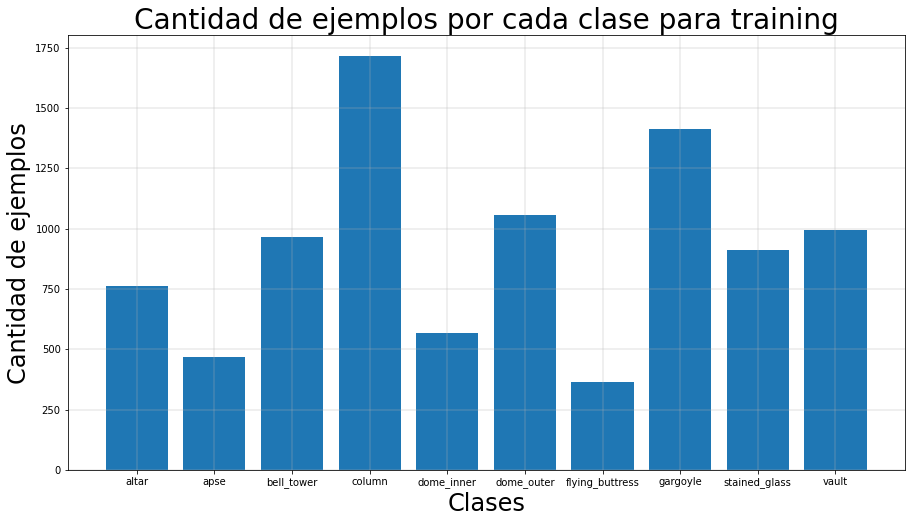

In [0]:
class_names = []
class_num = []
for key in train.class_indices:
    class_names.append(key)
    class_num.append(counter[train.class_indices[key]])

plt.figure(figsize=(15,8))
plt.bar(class_names, class_num, width=0.8)
#plt.legend(loc = 4,prop={'size':18})
plt.xlabel("Clases", fontsize = 24)
plt.ylabel("Cantidad de ejemplos", fontsize = 24)
plt.grid(True)
plt.grid(color = '0.7', linestyle = '-', linewidth = .4)
plt.axis('tight')
plt.title("Cantidad de ejemplos por cada clase para training",fontsize = 28, horizontalalignment = 'center')
plt.show()

## Primer Modelo CNN 

Utilizamos un modelo de red convolucional CCPCCPCCP

In [0]:
def ccpCnnModel():
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu', padding='same'))
    classifier.add(Dropout(0.2))
    classifier.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    classifier.add(MaxPooling2D())
    classifier.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    classifier.add(Dropout(0.2))
    classifier.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    classifier.add(MaxPooling2D())
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    classifier.add(Dropout(0.2))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    classifier.add(MaxPooling2D())
    classifier.add(Flatten())
    classifier.add(Dropout(0.2))
    classifier.add(Dense(1024, activation='relu', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    classifier.add(Dropout(0.25))
    classifier.add(Dense(512, activation='relu', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(10, activation='softmax'))

    classifier.compile(optimizer='adam', loss='categorical_crossentropy',
                      metrics=['accuracy',f1_m])
    
    return classifier

Se entrena el primer modelo, con x epochs

In [0]:
ccpCnnModel = ccpCnnModel()
cppCnnHistory=ccpCnnModel.fit_generator(generator=train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid,
                    validation_steps=STEP_SIZE_VALID,
                    #class_weight=class_weights,
                    epochs=70)

In [0]:
#print(cppCnnHistory.history.keys())

In [0]:
def plot_loss(hist):
  plt.figure(figsize=(15,8))
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()

In [0]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.engine.input_layer import Input

def modelVGG():
    model = VGG16(weights='imagenet', include_top=False ) # LOAD PRETRAINED MODEL 
    for layer in model.layers[:]:
        layer.trainable = False
    model_input = Input(shape=(128, 128, 3))
    x = model(model_input)
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    #x = Dense(128, activation = 'relu')(x)
    #x = Dropout(0.5)(x)
    
    #y = Dense(512, activation = 'relu')(x)
    #y = Dropout(0.5)(y)
    y = Dense(512, activation = 'relu')(x)
    y = Dropout(0.5)(y)
    
    y = Dense(10, activation= 'softmax')(y)
    
    model = Model(inputs=model_input, outputs = [y])
    model.summary()
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                       metrics=['accuracy',f1_m])
    return model

In [0]:
modelVgg = modelVGG()

vggHistory=modelVgg.fit_generator(generator=train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid,
                    validation_steps=STEP_SIZE_VALID,
                    #class_weight=class_weights,
                    epochs=60)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
global_max_pooling2d_9 (Glob (None, 512)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_40 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_41 (Dropout)         (None, 512)               0   

In [0]:
y_pred = modelVgg.predict_generator(test)
y_pred = np.argmax(y_pred, axis=1)

In [0]:
def saveCSV(model_pred,train_generator,test_generator):
    # Create submission df
    submission_df = pd.DataFrame({
        'Id':test_generator.filenames,
        'Expected':model_pred })
    # Filename is id, remove extension .tif
    submission_df['Id'] = submission_df['Id'].apply(lambda x: x.split('.')[0])
    #print(f"Submission dataframe created. Rows:{len(submission_df.values)}")
    
    for key in train_generator.class_indices:
        submission_df['Expected'] = submission_df['Expected'].replace(train_generator.class_indices[key],key)
    
    submission_df.to_csv('submission-Vgg-FF-2.csv', index=False)
    return submission_df

In [0]:
saveCSV(y_pred,train,test)

,Id,Expected
0,test_145,stained_glass
1,test_244,column
2,test_447,dome_outer
3,test_563,column
4,test_773,altar
...,...,...
1018,test_743,stained_glass
1019,test_836,column
1020,test_835,gargoyle
1021,test_148,column


## 2.2 Analisis con redes neuronales pre-entrenadas

Luego se analizó con redes pre-entrenadas que vienen en la libería keras. Analizamos varias de ellas ejecutandolas primero hasta con 7 epoch para seleccionar las que mejor resultados tienen.

In [0]:
#importación de librerias
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras import regularizers, optimizers, Model 
#import pandas as pd
import numpy as np
from keras import metrics
from sklearn.utils import class_weight
from keras.optimizers import SGD, rmsprop

from keras_preprocessing.image import ImageDataGenerator
import pandas as pd

import matplotlib.pyplot as plt

from collections import Counter

In [0]:
labels=pd.read_csv(r"/kaggle/input/dataset/data/train_labels.csv")
path = "/kaggle/input/dataset/data/"

In [0]:
def append_ext(fn):
    return fn+".jpg"

traindf=pd.read_csv(path+'train_labels.csv',dtype=str)

traindf["Id"]=traindf["Id"].apply(append_ext)

Utilizamos las configuraciones que mejor resultados nos dio en la parte anterior más unos ajustes de esta misma etapa.

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.2, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.2, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False, # randomly flip images
    validation_split=0.2)
    
train_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=path+"train_images/",
    x_col="Id",
    y_col="Expected",
    subset="training",
    batch_size=32,
    seed=30,
    shuffle=True,
    class_mode="categorical",
    target_size=(128,128))

valid_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=path+"train_images/",
    x_col="Id",
    y_col="Expected",
    subset="validation",
    batch_size=32,
    seed=30,
    shuffle=True,
    class_mode="categorical",
    target_size=(128,128))

In [0]:
#Definicion de tamaño datos de entrenamiento y validacion
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [0]:
test_files_df=pd.DataFrame()
test_files_df['file']=os.listdir(path+'test_images')
#print("Loaded test files list")

In [0]:
test_generator=ImageDataGenerator(rescale=1. / 255).flow_from_dataframe(
                    dataframe=test_files_df,
                    directory=path+"test_images",
                    x_col="file",
                    y_col=None,
                    has_ext=True,
                    class_mode=None,
                    batch_size=32,
                    seed=30,
                    shuffle=False,
                    target_size=(128,128))  

Se define f1_m y se anlizan otras métricas:

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
metrics_modelo = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='categoricalAccuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
]
metrics_modelo.append(f1_m)

Se define un modelo común para todos para probar las distintas redes.

In [0]:
from keras.applications import VGG16, Xception, InceptionV3, VGG19, ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2, InceptionV3, InceptionResNetV2, MobileNet, MobileNetV2

In [0]:
def custom_model(tipo_modelo, dropout):
    from keras.models import Sequential
    base_model = tipo_modelo(weights='imagenet', include_top=False , input_shape= (128, 128, 3) ) # LOAD PRETRAINED MODEL 
    for layer in base_model.layers[:]:
        layer.trainable = False
    model = Sequential()
    model.add(base_model)
    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(dropout))
    
    #model.add(Dense(256, activation = 'relu'))
    #model.add(Dropout(dropout))
    
    #model.add(Dense(128, activation = 'relu'))
    #model.add(Dropout(dropout))
    
    #model.add(Dense(64, activation = 'relu'))
    #model.add(Dropout(dropout))
    
    model.add(Dense(10, activation= 'softmax'))

    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                       metrics=metrics_modelo)
    
    return model

In [0]:
Se define una funcion para realizar el entrenamiento con y sin validación

In [0]:
def custom_entrenamiento(epochs, model ,validation = True):
    if validation == True:
        hist_model=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    #class_weight=class_weights,
                    epochs=epochs)
    else:
        hist_model = model.fit_generator(
                    generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    #callbacks=callbacks_list,
                    epochs=epochs) 
    return hist_model

Por último se define una función para graficar

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, nombre_modelo):
  metrics =  ['loss', 'categoricalAccuracy', 'f1_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'categoricalAccuracy':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.savefig(nombre_modelo +'.png')

Finalmente se hacen las pruebas:

In [0]:
nombres = ['VGG16', 'Xception', 'InceptionV3', 'VGG19', 'ResNet50', 'ResNet101', 'ResNet152', 'ResNet50V2', 'ResNet101V2']
#saltar = ['VGG16', 'Xception', 'InceptionV3', 'VGG19', 'ResNet50', 'ResNet101', 'ResNet152', 'ResNet50V2']
contador = 0
for tipo_modelo in [VGG16, Xception, InceptionV3, VGG19, ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2, InceptionV3, InceptionResNetV2, MobileNet, MobileNetV2, DenseNet121, DenseNet169, DenseNet201, NASNetMobile, NASNetLarge]:
    #if nombres[contador] not in saltar: 
    print (nombres[contador])
    model1 = custom_model(tipo_modelo, 0.4)
    history = custom_entrenamiento(6, model1)
    plot_metrics(history, nombres[contador])
    contador += 1

Resultados con VGG16 ![Resultados con VGG16](https://i.ibb.co/f2539CQ/VGG16.png)

Resultados con ResNet101V2 ![Resultados con ResNet101V2](https://i.ibb.co/jGJJhLq/Res-Net101-V2.png)

Resultados con ResNet50 ![Resultados con ResNet50](https://i.ibb.co/t4wpMtk/ResNet50.png)

Resultados con ResNet50V2 ![Resultados con ResNet50V2](https://i.ibb.co/8536Dxb/Res-Net50-V2.png)

Resultados con VGG19 ![Resultados con VGG19](https://i.ibb.co/xHWxF0J/VGG19.png)

Resultados con ResNet152 ![Resultados con ResNet152](https://i.ibb.co/LJryFhH/Res-Net152.png)

Resultados con InceptionV3 ![Resultados con InceptionV3](https://i.ibb.co/HzpjVpH/Inception-V3.png)

Resultados con ResNet101 ![Resultados con ResNet101](https://i.ibb.co/jr973sN/Res-Net101.png)

Resultados con Xception ![Resultados con Xception](https://i.ibb.co/VjcNX76/Xception-1.png)

De las pruebas que se hicieron los mejores resultados se obtuvieron con VGG16. A partir de esto se realizan modificaciones al modelo y el entrenamiento con mas mas epoch. Finalmente con el siguiente modelo se obtuvieron mejores resultados

In [0]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.engine.input_layer import Input

def modelVGG():
    model = VGG16(weights='imagenet', include_top=False ) # LOAD PRETRAINED MODEL 
    for layer in model.layers[:]:
        layer.trainable = False
    model_input = Input(shape=(128, 128, 3))
    x = model(model_input)
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    
    y = Dense(128, activation = 'relu')(x)
    y = Dropout(0.2)(y)
    y = Dense(64, activation = 'relu')(y)
    y = Dropout(0.2)(y)
    
    y = Dense(10, activation= 'softmax')(y)
    
    model = Model(inputs=model_input, outputs = [y])
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                       metrics=metrics_modelo)
    
    return model

In [0]:
model1 = modelVGG()
history = custom_entrenamiento(6, model1, False)

Se realiza la predicción y se guardan

In [0]:
y_pred = model.predict_generator(test_generator)
y_pred_argmax = np.argmax(y_pred, axis=1)

In [0]:
#Se guarda los resultados
from numpy import asarray
from numpy import savetxt
# define data
data = y_pred
# save to csv file
savetxt('y_pred_modelVGG16_2.csv', data, delimiter=';')

In [0]:
# Create submission df
submission_df3 = pd.DataFrame({
    'Id':test_generator.filenames,
    'Expected':y_pred_argmax })
# Filename is id, remove extension .tif
submission_df3['Id'] = submission_df3['Id'].apply(lambda x: x.split('.')[0])
#print(f"Submission dataframe created. Rows:{len(submission_df.values)}")

for key in train_generator.class_indices:
    submission_df3['Expected'] = submission_df3['Expected'].replace(train_generator.class_indices[key],key)
    
submission_df3.to_csv('submission12_modelVGG16_2.csv', index=False)
submission_df3

### Método extra

Se elegieron 3 modelos pre-entrenados que hayan tenido mejores resultados pero que sean distintos entre ellos. Para eso se eligio Xception, VGG16 y ResNet50V2. Con los porcentajes de cada categoria en los resultados de cada foto del test, se sumaron estos resultados ponderandose con un factor dependiendo de que tan buenos resultados se obtuvieron con el modelo.

In [0]:
import pandas as pd 
import numpy as np

array_xception = pd.read_csv("/kaggle/input/arrays/array_xception.csv", sep=';',header=None) 
array_resnet50v2 = pd.read_csv("/kaggle/input/arrays2/array_resnet50v2.csv.csv", sep=';',header=None) 
array_vgg16 = pd.read_csv("/kaggle/input/arrays/array_vgg16.csv", sep=',',header=None) 

array_xception['Id'] = pd.read_csv("/kaggle/input/result/result_xception.csv", sep=',').replace(to_replace=r'test_*', value='', regex=True).astype({"Id": int})['Id']
array_resnet50v2['Id'] = pd.read_csv("/kaggle/input/arrays2/result_resnet50v2.csv", sep=',').replace(to_replace=r'test_*', value='', regex=True).astype({"Id": int})['Id']
array_vgg16['Id'] = pd.read_csv("/kaggle/input/result/result_vgg16.csv", sep=',').replace(to_replace=r'test_*', value='', regex=True).astype({"Id": int})['Id']


array_xception = array_xception.sort_values(by ='Id' ).drop(columns=['Id'])
array_resnet50v2 = array_resnet50v2.sort_values(by ='Id' ).drop(columns=['Id'])
array_vgg16 = array_vgg16.sort_values(by ='Id' ).drop(columns=['Id'])

resultado1 = np.argmax(array_xception.values, axis=1)
resultado2 = np.argmax(array_resnet50v2.values, axis=1)
resultado3 = np.argmax(array_vgg16.values, axis=1)

In [0]:
suma = array_xception.values + 1.3 * array_resnet50v2.values + 2.6 * array_vgg16.values
resultado = np.argmax(suma, axis=1)

In [0]:
# Create submission df
submission_df3 = pd.DataFrame({
    'Id':range(1023),
    'Expected':resultado })
submission_df3['Id'] = submission_df3['Id'].apply(lambda x: "test_"+ str(x))
for key in train_generator.class_indices:
    submission_df3['Expected'] = submission_df3['Expected'].replace(train_generator.class_indices[key],key)
    
submission_df3.to_csv('submission_extra.csv', index=False)
submission_df3[:55]